# Model Comparisons in Demand Forecasting for E-Commerce

**Objective:** an ecommerce platform aimed to predict customer demand to optimize pricing and inventory management.

**Approach:** time series data of customer browsing behavior, product views, and historical sales were collected. Multiple models were used to capture seasonality and long-term dependencies.

**Outcome:** accurate demand forecasts helped the e-commerce platform optimize pricing, improve product recommendations, and efficiently manage inventory, resulting in increased sales and customer retention.

In [1]:
import pandas as pd

data = pd.read_csv('../data_sets/demand.csv')

In [2]:
data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [3]:
# Check for null values

missing_values = data.isnull().sum()
missing_values

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [4]:
# Impute the missing value. Since it's one, you could just drop that row.

# However, we're going to fill it with .median()

median_price_per_sku = data.groupby('sku_id')['total_price'].median()
data['total_price'].fillna(data['sku_id'].map(median_price_per_sku), inplace=True)

# Double-check the missing value was filled
data.isnull().sum()

/var/folders/nd/f27d3d4969v06hd_stq0_5680000gn/T/ipykernel_79442/2904471217.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_price'].fillna(data['sku_id'].map(median_price_per_sku), inplace=True)


record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [7]:
# 'Week' is the best column for date. Convert 'week' to datetime

data['week'] = pd.to_datetime(data['week'], format='%d/%m/%y')

# Aggregate the day by week
weekly_data = data.groupby('week')['units_sold'].sum().reset_index()

# Display the first few rows of the aggregated data
weekly_data.head()

,week,units_sold
0,2011-01-17,60029
1,2011-01-24,56752
2,2011-01-31,51467
3,2011-02-07,54656
4,2011-02-14,109207


## EDA

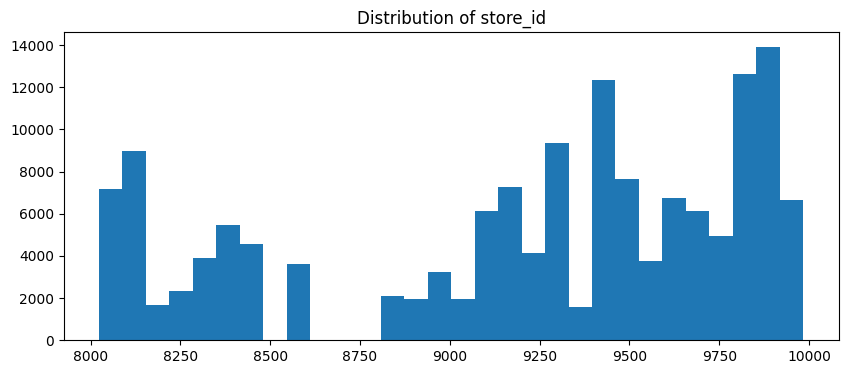

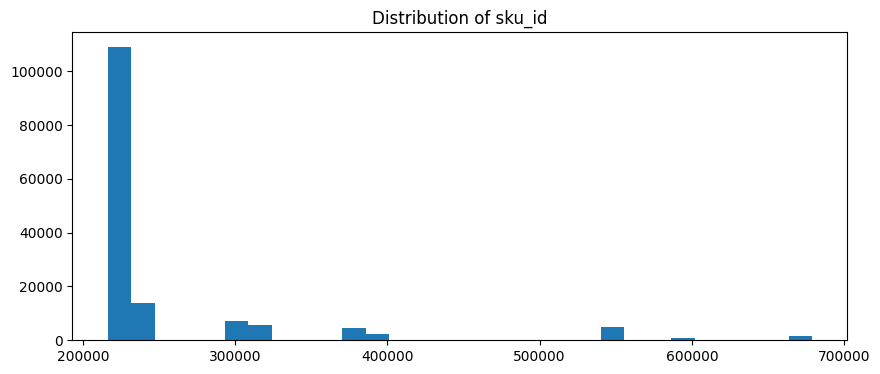

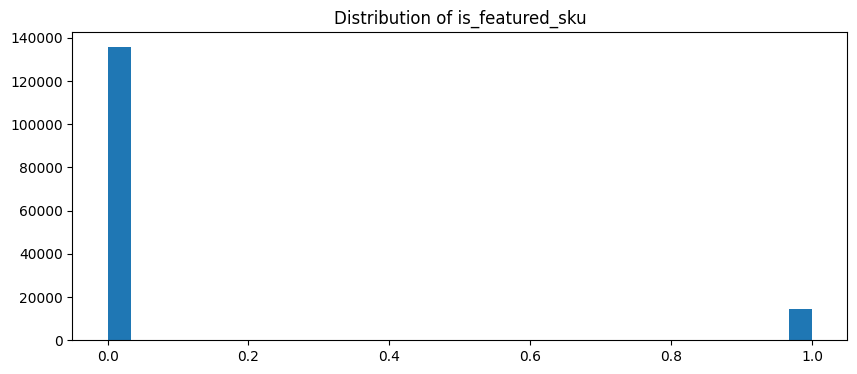

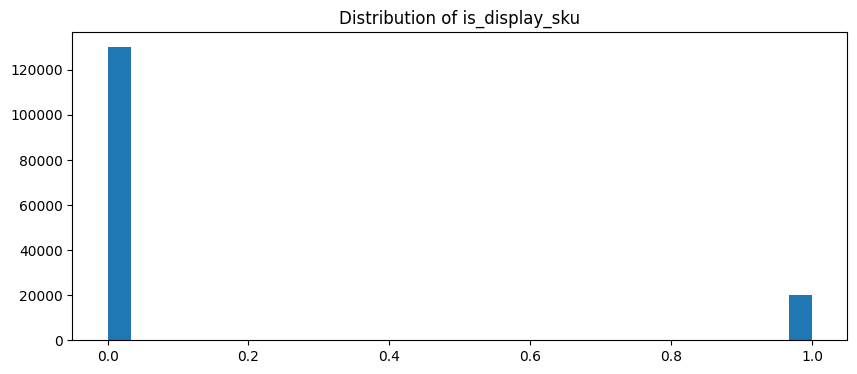

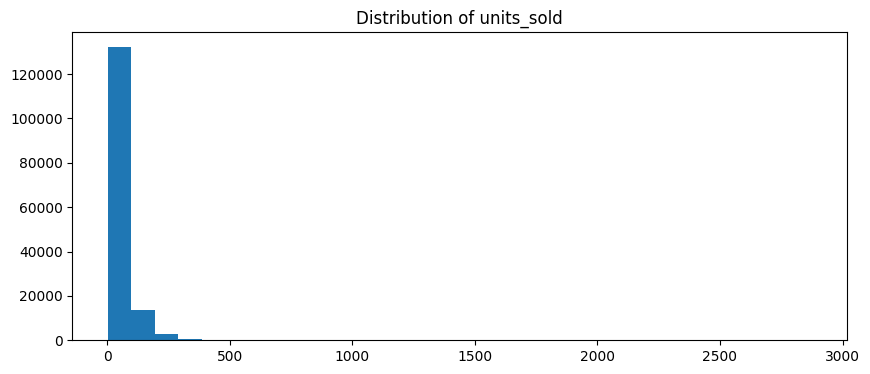

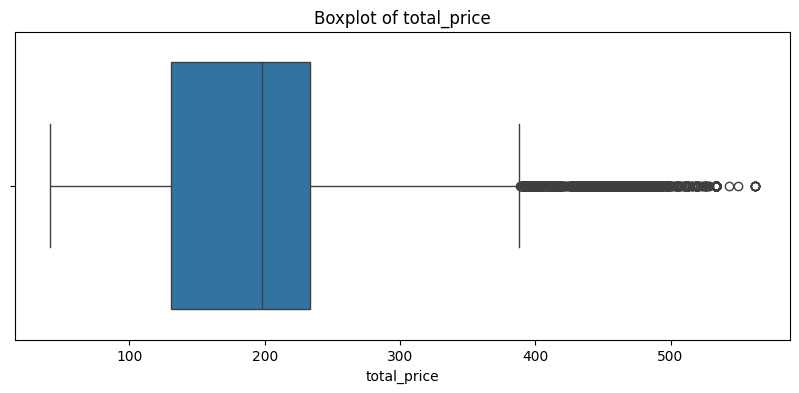

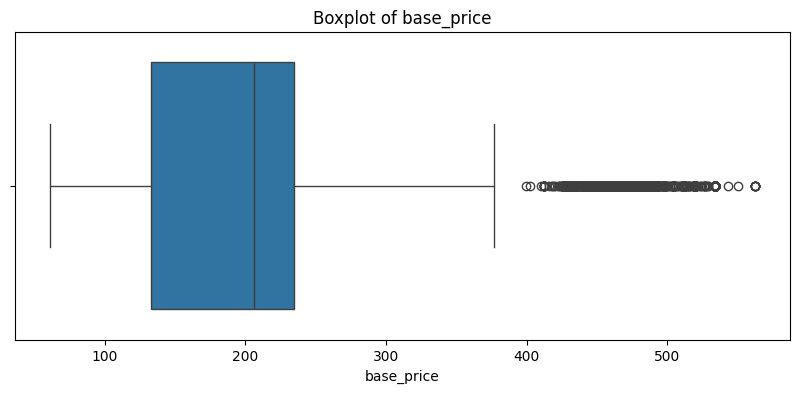

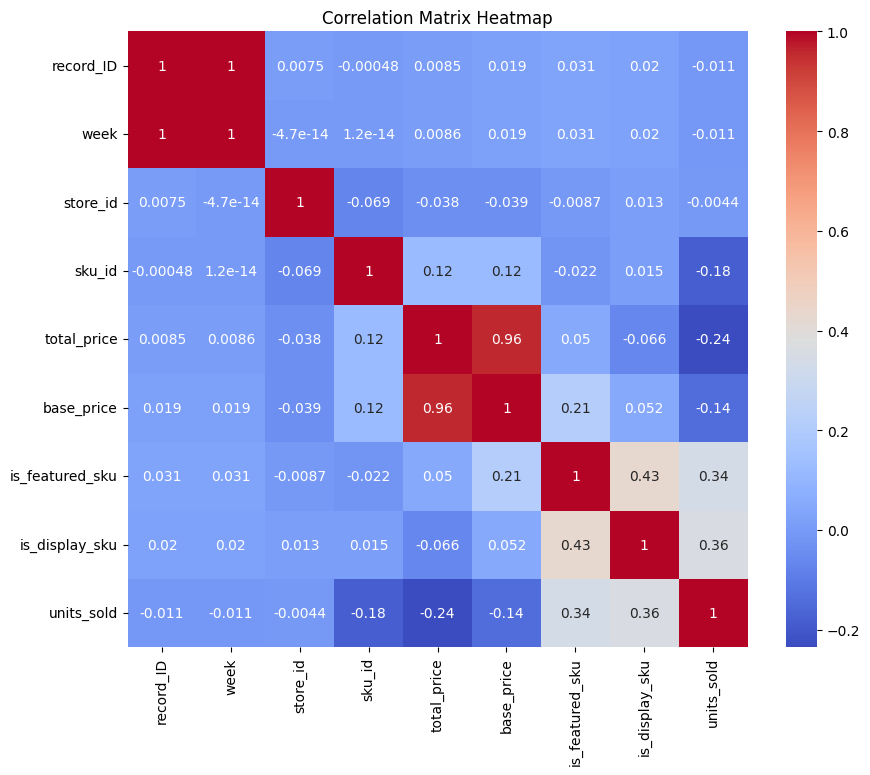

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot histograms for categorical columns and the target variable
categorical_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'units_sold']

# Plot histograms for categirocal columns and the target variable
cotegorical_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'units_sold']

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    plt.hist(data[col], bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Boxplot for numerical columns
numerical_cols = ['total_price', 'base_price']

for col in numerical_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Check the correlation between features
correlation = data.corr() # 1 = highly correlated, -1 = negatively correlated; close to 0 = not correlated

plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()